In [7]:
'''
Combines other dataframes
Uses feature tools for deep feature synthesis
'''

'\nCombines other dataframes\nUses feature tools for deep feature synthesis\n'

In [8]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# imports
from utils import *
from models import *

In [9]:
# read in data - limit to 1000 rows for now
app_test = pd.read_csv('../input/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True)

app_train = pd.read_csv('../input/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True)#.loc[:1000, :]
bureau = pd.read_csv('../input/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True)#.loc[:10000, :]
bureau_balance = pd.read_csv('../input/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True)#.loc[:10000, :]

# cash = pd.read_csv('../input/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:10000, :]
# credit = pd.read_csv('../input/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:10000, :]
# previous = pd.read_csv('../input/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:10000, :]
# installments = pd.read_csv('../input/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:10000, :]


In [10]:
# Combine the train and test to a single df (stack train on test). This means all processing can be done on both in 1 go
# LEAKING MAY BE A ISSUE! 
def combine_app_train_test(train, test):
    # Add identifying column
    train['set'] = 'train'
    test['set'] = 'test'
    test["TARGET"] = np.nan

    # Append the dataframes
    app = train.append(test, ignore_index = True)
    return app

app = combine_app_train_test(app_train, app_test)


In [12]:

def add_entities(entity_set):
    # Add the different entities (tables) to the entityset
    entity_set = entity_set.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')
    entity_set = entity_set.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')
    entity_set = entity_set.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

    # For entitites which do not have a unique index column, create one
    # This will update the original dataframe with new indexes 
    entity_set = entity_set.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                                  make_index = True, index = 'bureau_balance_index')
    
    entity_set = entity_set.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')
    
    entity_set = entity_set.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')
    
    entity_set = entity_set.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')
    return entity_set

# Entitiy set (es) stores all data. Entity ~ table
es = ft.EntitySet(id = 'clients')
es = add_entities(es)
es

NameError: name 'previous' is not defined

In [5]:
def add_relationships(entity_set):
    # Relationship between app and bureau
    rel_app_bureau = ft.Relationship(entity_set['app']['SK_ID_CURR'], entity_set['bureau']['SK_ID_CURR'])

    # Relationship between bureau and bureau balance
    rel_bureau_balance = ft.Relationship(entity_set['bureau']['SK_ID_BUREAU'], entity_set['bureau_balance']['SK_ID_BUREAU'])

    # Relationship between current app and previous apps
    rel_app_previous = ft.Relationship(entity_set['app']['SK_ID_CURR'], entity_set['previous']['SK_ID_CURR'])
    
    # Relationships between previous apps and cash, installments, and credit
    rel_previous_cash = ft.Relationship(entity_set['previous']['SK_ID_PREV'], entity_set['cash']['SK_ID_PREV'])
    rel_previous_installments = ft.Relationship(entity_set['previous']['SK_ID_PREV'], entity_set['installments']['SK_ID_PREV'])
    rel_previous_credit = ft.Relationship(entity_set['previous']['SK_ID_PREV'], entity_set['credit']['SK_ID_PREV'])

    # Add in the defined relationships
    entity_set = entity_set.add_relationships([rel_app_bureau, rel_bureau_balance, rel_app_previous,
                           rel_previous_cash, rel_previous_installments, rel_previous_credit])
    return entity_set

es = add_relationships(es)

In [6]:
# # Default primitives from featuretools
# default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "mode"]
# default_trans_primitives = []
# # default_trans_primitives =  ["day", "year", "month"]

# # DFS with specified primitives
# feature_names = ft.dfs(entityset = es, target_entity = 'app',
#                        trans_primitives = default_trans_primitives,
#                        agg_primitives=default_agg_primitives, 
#                        max_depth = 2, features_only=True)

# print('%d Total Features' % len(feature_names))
es

Entityset: clients
  Entities:
    app [Rows: 49745, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [6]:
def create_deep_synthetic_features(entity_set, agg_primitives, trans_primitives=[], target_entity='app', max_depth = 2):
    # DFS with default primitives
    features, feature_names = ft.dfs(entityset = entity_set, target_entity = target_entity,
                                           trans_primitives = trans_primitives,
                                           agg_primitives=agg_primitives, 
                                            max_depth = 2, features_only=False, verbose = True)

    return features, feature_names

agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "mode"]
trans_primitives = []

ds_features, ds_feature_names = create_deep_synthetic_features(es, agg_primitives, trans_primitives)
# pd.options.display.max_columns = 1700
ds_feature_names[-20:]


Built 1654 features
Elapsed: 06:20 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| Calculated: 11/11 chunks


[<Feature: SKEW(bureau.SUM(bureau_balance.MONTHS_BALANCE))>,
 <Feature: SKEW(bureau.STD(bureau_balance.MONTHS_BALANCE))>,
 <Feature: SKEW(bureau.MAX(bureau_balance.MONTHS_BALANCE))>,
 <Feature: SKEW(bureau.MIN(bureau_balance.MONTHS_BALANCE))>,
 <Feature: SKEW(bureau.MEAN(bureau_balance.MONTHS_BALANCE))>,
 <Feature: SKEW(bureau.COUNT(bureau_balance))>,
 <Feature: MIN(bureau.SUM(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MIN(bureau.STD(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MIN(bureau.MAX(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MIN(bureau.SKEW(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MIN(bureau.MEAN(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MIN(bureau.COUNT(bureau_balance))>,
 <Feature: MEAN(bureau.SUM(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MEAN(bureau.STD(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MEAN(bureau.MAX(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MEAN(bureau.SKEW(bureau_balance.MONTHS_BALANCE))>,
 <Feature: MEAN(bureau.MIN(bureau_balance.MONTHS_BAL

In [7]:
from featuretools import selection
all_ds_features = ds_features.copy()
# Remove features with only one unique value
ds_features = selection.remove_low_information_features(ds_features)

print('Removed %d features' % (all_ds_features.shape[1]- ds_features.shape[1]))

Removed 162 features


In [134]:
# Find correlations wrt to training data columns
# df = ds_features[ds_features['set'] == 'train']
# df = df.drop(columns = ['set'])
# dsf_corrs = df.corr()
# correlations_target = dsf_corrs.sort_values('TARGET')['TARGET']
# correlations_target.dropna().tail(), correlations_target.head()

KeyboardInterrupt: 

In [ ]:
# import seaborn as sns
# def kde_target_plot(df, feature):
#     """Kernel density estimate plot of a feature colored
#     by value of the target."""
    
#     # Need to reset index for loc to workBU
#     df = df.reset_index()
#     plt.figure(figsize = (10, 6))
#     plt.style.use('fivethirtyeight')
    
#     # plot repaid loans
#     sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
#     # plot loans that were not repaid
#     sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
#     # Label the plots
#     plt.title('Distribution of Feature by Target Value')
#     plt.xlabel('%s' % feature); plt.ylabel('Density');
#     plt.show()

# kde_target_plot(ds_features, feature = 'MIN(previous.SKEW(installments.NUM_INSTALMENT_VERSION))')

In [8]:
# Separate out the train and test sets
train = ds_features[ds_features['set'] == 'train']
test = ds_features[ds_features['set'] == 'test']

# # One hot encoding
# train = pd.get_dummies(train)
# test = pd.get_dummies(test)

# # Align dataframes on the columns
# train, test = train.align(test, join = 'inner', axis = 1)
train = train.drop(columns = ['set'])

test = test.drop(columns = ['TARGET'])
test = test.drop(columns = ['set'])

print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (307511, 1491)
Testing Shape:  (48744, 1490)


ONE HOT ENCODED
Training Features shape:  (307511, 1728)
Testing Features shape:  (48744, 1699)
ALIGNED:
Training Features shape:  (307511, 1696)
Testing Features shape:  (48744, 1695)
There were 9274 anomalies in the test data out of 48744 entries
REMOVING COLUMNS WITH 0.9 MISSING VALUES
Training Features shape:  (307511, 577)
Testing Features shape:  (48744, 1696)
Training Features shape:  (307511, 577)
Testing Features shape:  (48744, 576)


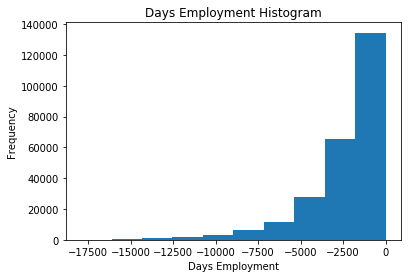

In [9]:
# do basic pre-processing
def pre_process(train_data, test_data):
#     train_data, test_data = encode_binary_cols(train_data, test_data) # purposefully left out - was taking too long
    train_data, test_data = one_hot_encode(train_data, test_data)
    train_data, test_data, train_Y = align_data(train_data, test_data)
    train_data, test_data = remove_days_employed_anomaly(train_data, test_data)
    
    train_data, test_data = remove_missing_cols(train_data, test_data, thr=0.90)
    
    train_data = mean_impute(train_data)
    test_data = mean_impute(test_data)

    return train_data, test_data

train_data, test_data = pre_process(train, test)

In [10]:
# Do final processing to get aligned train and test set with training labels 
train_X, test_X , train_Y= align_data(train_data, test_data)
train_X = train_X.drop(columns=['TARGET'])
feature_names = train_X.columns
# train_X = train_X.drop(columns=['SK_ID_CURR'])
# test_X = test_X.drop(columns=['SK_ID_CURR'])
print('Training Data Shape: ', train_X.shape)
print('Testing Data Shape: ', test_X.shape)
feature_names = train_X.columns

# train_X, train_Y = oversample(train_X, train_Y)
# train_X, test_X = normalise(train_X, test_X)
train_Y = train_Y.values # no need for sk_curr_id

ALIGNED:
Training Features shape:  (307511, 577)
Testing Features shape:  (48744, 576)
Training Data Shape:  (307511, 576)
Testing Data Shape:  (48744, 576)


In [11]:
train_X = train_X.reset_index().drop(columns='SK_ID_CURR').values
test_X = test_X.reset_index().drop(columns='SK_ID_CURR')

C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Run 0 AUC socre: 0.580604627971613


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Run 1 AUC socre: 0.5868803833282887


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Run 2 AUC socre: 0.5867162837122049


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Run 3 AUC socre: 0.5763320138875143


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Run 4 AUC socre: 0.5903136739323253


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Run 5 AUC socre: 0.5872924224169255
Avg ROC AUC score: 0.584689900874812


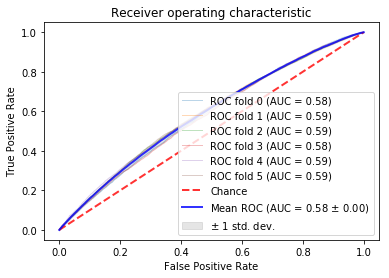

In [12]:
model, predictions = baseline_log_reg(train_X, train_Y, test_X, save_path=None) # don't save model
cross_val_roc_curve(train_X, train_Y, model)
# create_and_save_submission(app_test, predictions, save_path='../test_predictions/test.csv')

In [13]:
# lgbm model - overfits slightly on training 

test_Y, feature_importances, score_metrics = gbm_basic(train_X, train_Y, test_X, feature_names, 
        model_save_path='../models/test.pickle' ,n_folds=5)
print(score_metrics)
# create_and_save_submission(app_test, test_Y, save_path='../test_predictions/test.csv')

Training Data Shape:  (307511, 576)
Testing Data Shape:  (48744, 576)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.753415	valid's binary_logloss: 0.564642	train's auc: 0.797156	train's binary_logloss: 0.554211
Early stopping, best iteration is:
[186]	valid's auc: 0.753474	valid's binary_logloss: 0.565949	train's auc: 0.794898	train's binary_logloss: 0.556167
File saved at  ../models/test.pickle
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.757543	valid's binary_logloss: 0.564979	train's auc: 0.79669	train's binary_logloss: 0.55483
[400]	valid's auc: 0.757781	valid's binary_logloss: 0.547795	train's auc: 0.825532	train's binary_logloss: 0.529142
Early stopping, best iteration is:
[340]	valid's auc: 0.757967	valid's binary_logloss: 0.552507	train's auc: 0.817699	train's binary_logloss: 0.536267
File saved at  ../models/test.pickle
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 

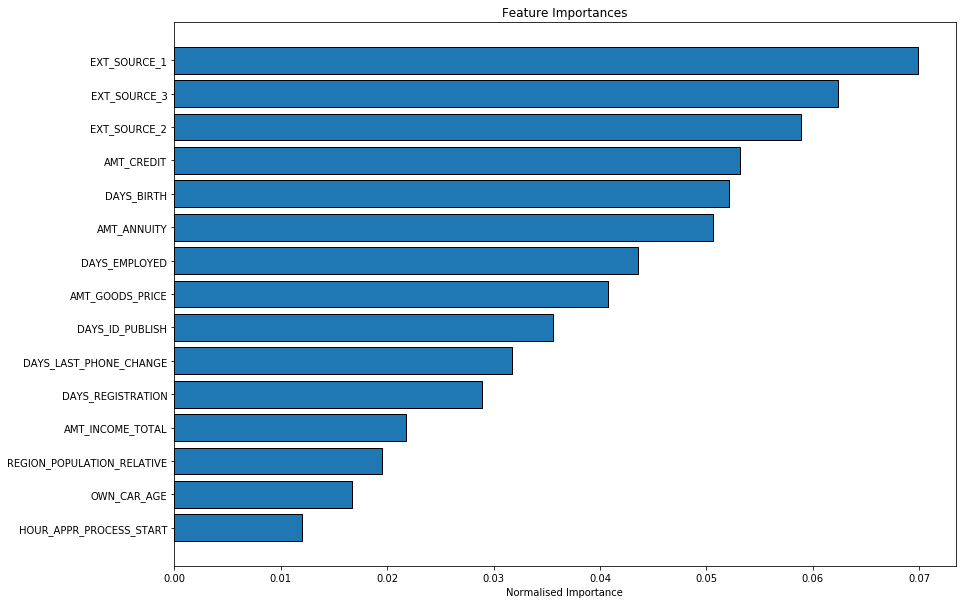

In [21]:
fi = plot_feature_importances(feature_importances, n=15)

In [23]:
create_and_save_submission(app_test, test_Y, save_path='../test_predictions/test_dsf_lgbm.csv')

Predictions saved to:  ../test_predictions/test_dsf_lgbm.csv


In [45]:
# just in app_train, app_test and previous
df = installments
for col in df.columns:
    if "DAYS" in col:
        print(col, df[col][df[col]== 365243].shape)

DAYS_INSTALMENT (0,)
DAYS_ENTRY_PAYMENT (0,)
